In [75]:
import numpy as np
import pandas as pd

import numpy as np
from pandas.tseries.offsets import BDay
import math
import random

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()
%matplotlib inline

In [31]:
import ffn

ImportError: cannot import name 'StringIO' from 'pandas.compat' (C:\Users\lexik\.conda\envs\quant\lib\site-packages\pandas\compat\__init__.py)

In [76]:
from pyfinance import TSeries


In [77]:
from hurst import compute_Hc, random_walk

In [315]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from hurst import compute_Hc, random_walk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

In [79]:
def ShannonFast(df):
    # wrong pattern match
    df=df[df!=0.0]
    shift_returns = df.shift(1)
    shift_returns2 = df.shift(2)
    shift_returns3 = df.shift(3)
    
    #df['test']  = np.sign(df['returns']).astype('str').dropna() + np.sign(df['shift_returns2']).astype('str').dropna() +  np.sign(df['shift_returns3']).dropna().astype('str')
    
    df =df.dropna(axis=0)
    
    Pattern  = np.sign(df.shift(1).dropna()).astype('str') + np.sign(shift_returns2.dropna()).astype('str') +  np.sign(shift_returns3.dropna()).astype('str')
    
    Pattern=Pattern.dropna().str.replace('.0','')
    patternList = Pattern.dropna().str.replace('.0','').unique().tolist()
    total = 0.0
    ShannonPatterns = {}
    
    for e in patternList:
        ShannonPatterns[e] = 0

    for pattern in ShannonPatterns.keys():        
        value = (len(np.where(Pattern==pattern)[0]))
        ShannonPatterns[pattern] +=  value
        total += value
        
    
    ProbSum = 0.0
    for pattern in ShannonPatterns.keys():
        p = ShannonPatterns[pattern] / total        
        value = p * np.log2(p)        
        if math.isnan(value):
            continue
        ProbSum = ProbSum + value
    Shannon_val = -ProbSum
    return Shannon_val

def Shannon(df, patternSize):
    
    chunks = []
    for i in range(0, len(df)):
        chunks.append(df[i:i+patternSize])
    
    chunks = chunks[:-patternSize-1]
    
    
    chunks = [np.array2string(x) for x in chunks.copy()]
    
    
    
    
    chunks_set = list(set(chunks))
    
    
    visited = {}
    total = 0
    for el in chunks_set:
        if (el not in visited):
            f = chunks.count(el)
            visited[el] = f
            total = total + f
    ProbSum = 0.0
    for el in visited:
        p = visited[el]/total
        value = p * np.log2(p)
        #visited[el] = value
        ProbSum = ProbSum + value
    Shannon_val = -ProbSum
    del visited, chunks
    
    
    
    return Shannon_val

def marketMeannes(df_):
    
    m = np.median(df_) 
    nh = 0
    nl = 0
    
    for i in range(1, len(df_)-1):
        Pt = df_[i]
        Py = df_[i-1]
        
        if (Py > m) & (Py > Pt):
            nl += 1
        elif (Py < m) & (Py < Pt):
            nh += 1
        else:
            None
    return (nl+nh)/(len(df_)-1)
        
    
    
def Momersion(df):
    #print(np.where(df == 1)[0])
    #df = df['returns'].copy() * df['returns'].shift(1)
    df = df.copy() * df.shift(1)
    
    df = df.dropna()
    df = np.sign(df)
    pos = len(np.where(df == 1)[0])
    neg = len(np.where(df == -1)[0])
    #zero = len(np.where(df == 0.0)[0])
    if (pos + neg) == 0.0:
        return -1.0
    #print(pos, neg)
    mom = (pos / (pos+neg )) #*100.0
    return mom
# https://pypi.org/project/hurst/
def hurst(ts):
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # plot on log-log scale
    #plt.plot(np.log(lags), np.log(tau)); plt.show()
    # calculate Hurst as slope of log-log plot
    #print(lags, tau)
    m = np.polyfit(np.log(lags), np.log(tau), 1)

 
    hurst = m[0]*2.0
    #print ('hurst = ',hurst)
    #plt.clf(), plt.close()
    return hurst

def MomersionDouble(df):

    df = df[df!=0.0]
    shift_returns = df.shift(1).fillna(0)
    shift_returns2 = df.shift(2).fillna(0)
    shift_returns3 = df.shift(3).fillna(0)
    Pattern = np.sign(shift_returns * shift_returns2)
    Pattern2= np.sign(shift_returns2 * shift_returns3)
    df = df.dropna()

    pp = len(np.where( (Pattern == 1 ) & (Pattern2 == 1 ) )[0])
    pm = len(np.where( (Pattern == 1 ) & (Pattern2 == -1 ) )[0])
    mp = len(np.where( (Pattern == -1 ) & (Pattern2 == 1 ) )[0])
    mm = len(np.where( (Pattern == -1 ) & (Pattern2 == -1 ) )[0])

    total = (pp+pm-mp-mm)/(df.count()-1.0)
    #threshUp = total>=np.sqrt(len(df))

    return total #(total, len(df), np.sqrt(len(df)))

def proportion(df):
    pp = len(np.where( (df >0.0  ) )[0])
    mm = len(np.where( (df < 0.0 ) )[0])
    
    if mm == 0.0 or mm is None:
        mm = 1
    return pp/mm
    
def proportionPos(df):
    pp = len(np.where( (df >0.0  ) )[0])
    mm = len(np.where( (df < 0.0 ) )[0])
    
    if mm == 0.0 or mm is None:
        mm = 1
    return 100.0 * pp/(pp+mm) 

def autoCorrel(df, lag):
    return pd.Series.autocorr(df, lag)


def hurstF(ts):
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # plot on log-log scale
    #plt.plot(np.log(lags), np.log(tau)); plt.show()
    # calculate Hurst as slope of log-log plot
    #print(lags, tau)
    m = np.polyfit(np.log(lags), np.log(tau), 1)

 
    hurst = m[0]*2.0
    #print ('hurst = ',hurst)
    #plt.clf(), plt.close()
    return hurst


def hurstF2(p):
    lags = range(2,100)


    variancetau = []; tau = []

    for lag in lags: 

        #  Write the different lags into a vector to compute a set of tau or lags
        tau.append(lag)

        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = np.subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    #print tau
    #print variancetau

    # plot the log of those variance against the log of tau and get the slope
    m = np.polyfit(np.log10(tau),np.log10(variancetau),1)

    hurst = m[0] / 2

    return hurst

def hurstF3(series):
   

    #H, c, data = compute_Hc(series.replace([np.inf, -np.inf], np.na).dropna(), kind='price', simplified=True)
    H, c, data = compute_Hc(series.replace([np.inf, -np.inf], np.nan).dropna(), kind='random_walk', simplified=False)
    return H

def hurstF4(series):
   
    
    H, c, data = compute_Hc(series, kind='random_walk', simplified=True)
    return H



In [80]:
def generateRWI2(df):
    MomVal = Momersion(df['returns']) 
    MomDouble = MomersionDouble(df['returns'])
 
    h1 =  hurstF(df['price'])
    h2 =  hurstF2(df['price'])
    h3 =  hurstF3(df['price'])

    h4 = hurstF4(df['price'])
   
  
    #df = df.copy().join(autoCorr_features(df[['returns']].copy()), rsuffix='_suka_')
    
    MMIR = marketMeannes(df['returns'])
    
    MMIP = marketMeannes(df['price'])
    ShannonVal = ShannonFast(df['returns'])
    prop = proportionPos(df['returns'])
    correl_1 = autoCorrel(df.returns, 1)
    correl_2 = autoCorrel(df.returns, 2)
    correl_3 = autoCorrel(df.returns, 3)
    correl_4 = autoCorrel(df.returns, 4)
    correl_5 = autoCorrel(df.returns, 5)
    correl_10 = autoCorrel(df.returns, 10)
    correl_20 = autoCorrel(df.returns, 20)
    correl_100 = autoCorrel(df.returns, 100)
    correl_list = [correl_1, correl_2, correl_3, correl_4, correl_5, correl_10, correl_20, correl_100]
    
    var_std = df['returns'].std()
    var_mean = df['returns'].mean()
    var_median = df['returns'].mean()
    
    
    return [MomVal, MomDouble, h1, h2, h3, h4, MMIR, MMIP, ShannonVal, prop, var_std, var_mean, var_median] + correl_list

In [81]:
### generate and stitch dataset

In [249]:
def generate_features(df):
    
    
    df['returns'] = np.log(df['price']).pct_change(1)
    
    df['ROC_2'] =  np.log(df['price'].copy()).pct_change(2)
    
    df['ROC_3'] = np.log(df['price'].copy()).pct_change(3)
    df['ROC_5'] = np.log(df['price'].copy()).pct_change(5)
    df['ROC_20'] = np.log(df['price'].copy()).pct_change(20)
    df['ROC_50'] = np.log(df['price'].copy()).pct_change(50)
    df['ROC_100'] = np.log(df['price'].copy()).pct_change(100)
    df['ROC_200'] = np.log(df['price'].copy()).pct_change(200)
    #df['ROC_300'] = np.log(df['price'].copy()).pct_change(300)
    df['ROC_500'] = np.log(df['price'].copy()).pct_change(500)
    
    
    df['abs_returns'] = np.abs( np.log(np.abs(df['price'].copy())).pct_change())
    

    df = df.replace([np.inf, -np.inf], np.nan)
    
    
    
    return df

In [83]:
def transform_series(tmp):
    #tmp = [e[0] if (type(e)==np.ndarray) else e for e in tmp.copy()]
    df = pd.DataFrame(np.asarray(tmp)+100)
    scaler = MinMaxScaler(feature_range=(0.0, 1.0))
    df_ = scaler.fit_transform(df)
    df_ = pd.DataFrame(df_, columns=df.columns,index=df.index)
    df = (100+df_*100)
    return df

In [84]:
main = pd.read_csv('btc hourly dataset/Bitfinex_BTCUSD_1h.csv')

In [85]:
main.Date.head()

0    2017-10-09 01-PM
1    2017-10-09 02-PM
2    2017-10-09 03-PM
3    2017-10-09 04-PM
4    2017-10-09 05-PM
Name: Date, dtype: object

In [86]:
main['Date'] = pd.to_datetime(main['Date'],  format='%Y-%m-%d %I-%p')

In [87]:
main = main.sort_values(by='Date').set_index('Date')

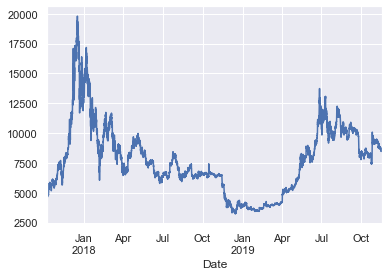

In [88]:
main['Close'].plot()

In [89]:
main = main[['Close']]

In [90]:
main = main.rename(columns={'Close':'price'})


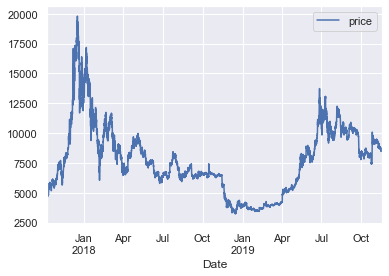

In [91]:
main.plot()
plt.axvline(1000, color='r')
plt.axvline(2000, color='r')
plt.axvline(3000, color='r')
plt.axvline(4000, color='r')
plt.axvline(5000, color='r')
plt.axvline(6000, color='r')
plt.axvline(7000, color='r')
plt.axvline(8000, color='r')
plt.axvline(9000, color='r')
plt.axvline(10000, color='r')
plt.axvline(11000, color='r')

In [92]:
#main.to_pickle('combined series main2.pkl')

In [93]:
returns = main.pct_change().rename(columns={0:'returns'}).dropna()

In [94]:
main['returns'] = returns

In [95]:
def ShannonReallyFast(shannon_df):
    #print(shannon_df, 'suka')
    patterns = {'000', '001', '010', '100', '101', '110', '011', '111'}
    shannon_df = pd.DataFrame(shannon_df.copy(), columns=['returns'])
    shannon_df['pattern1'] = np.sign(shannon_df[['returns']])
    shannon_df['pattern2'] = np.sign(shannon_df[['returns']].shift(1))
    shannon_df['pattern3'] = np.sign(shannon_df[['returns']].shift(2))
    shannon_df.dropna(inplace=True)
    shannon_df = shannon_df[(shannon_df.pattern1 != 0.0) & (shannon_df.pattern2 != 0.0) & (shannon_df.pattern3 != 0.0)]
    shannon_df['merged'] = shannon_df.pattern1.astype('str') + shannon_df.pattern2.astype('str') + shannon_df.pattern3.astype('str')
    shannon_df['merged'] = shannon_df['merged'].str.replace('.0', '')
    shannon_df['merged'] = shannon_df['merged'].str.replace('-1', '0')
    prob_df = shannon_df.groupby('merged').count()['returns']
    pattern_df = pd.DataFrame(patterns).set_index(0).sort_values(by=0)
    #prob_df = prob_df.drop(index='111')
    pattern_df = pattern_df.join(prob_df).fillna(0)
    
    ProbSum = 0.0
    for pattern in patterns:
        
        p = pattern_df.loc[pattern] / pattern_df.returns.sum()      
        value = p * np.log2(p)        
        if math.isnan(value):
            continue
        ProbSum = ProbSum + value
    Shannon_val = -ProbSum
    
    return Shannon_val
    

In [96]:
ShannonReallyFast(main[main.returns!= 0.0][['returns']])

C:\Users\lexik\.conda\envs\quant\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sign
  """
C:\Users\lexik\.conda\envs\quant\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sign
  
C:\Users\lexik\.conda\envs\quant\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sign
  import sys


returns    2.98379
dtype: float64

In [97]:
ShannonFast(main[main.returns!= 0.0]['returns'])

2.983791515050696

In [98]:
import time

In [175]:
proportionPos(main.returns)

50.684035537145036

In [176]:
proportionPos(main.loc['2019-09-01':]['returns'])

47.92228818132757

In [239]:
main = main.rename(columns={0:'price'})
main['returns'] = main.price.pct_change().fillna(0)
main['hurst'] = main[['returns']].rolling(500).apply(autoCorrel, args=[3], raw=False) #.plot()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D707111988>,
      dtype=object)

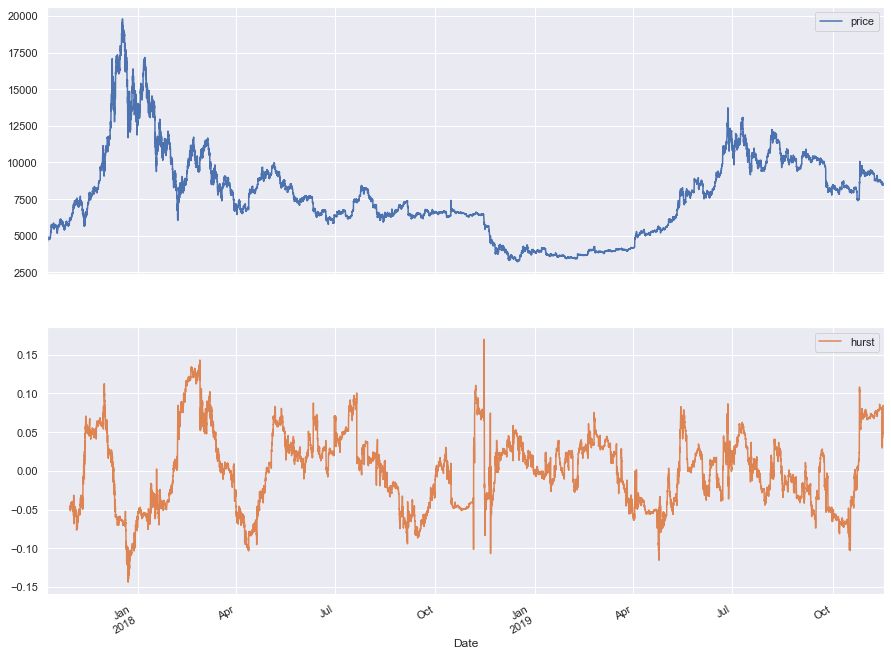

In [240]:
main[['price' ,'hurst']].plot(figsize=(15,12), subplots=(2,1))

In [261]:
df.shape[0] - df.shape[0] * 0.2

14280.0

In [262]:
results = []
df=main.copy()
df = df.replace([np.inf, -np.inf],0).fillna(0)

res = generate_features(df)
df = res.copy()
df['shift_returns'] = df['returns'].shift(-1).dropna()
df = df[df.shift_returns != 0.0].dropna()
y = df.iloc[:, [-1]]
y.shift_returns = np.sign(y.shift_returns)
X = df.iloc[:, 0:7]

rwi_list = generateRWI2(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train =X.iloc[0:14280]
y_train = y[0:14280]
X_test = X.iloc[15000:]
y_test = y.iloc[15000:]

clf = RandomForestClassifier(n_estimators=200, max_depth=20,
                             random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)

rwi_list.append(score)
results.append(rwi_list)


In [264]:
score

0.5414035087719298

In [17]:
# r, r, Mean-Reversal, random, trend, random

In [253]:
cols = ['MomVal', 'MomDouble', 'h1', 'h2', 'h3', 'h4', 'MMIR', 'MMIP', 'ShannonVal', 'prop', 'var_std', 'var_mean', 'var_median',   'correl_1', 'correl_2', 'correl_3', 'correl_4', 'correl_5', 'correl_10', 'correl_20', 'correl_100' ,   'score']

In [254]:
accuracy_df = pd.DataFrame(results, columns=cols) #.corr(method='spearman')['score'].sort_values()

In [255]:
import warnings
warnings.filterwarnings('ignore')

In [256]:
accuracy_df.T

,0
MomVal,0.452493
MomDouble,-0.094601
h1,NaN
h2,NaN
h3,0.557236
h4,0.520451
MMIR,0.761947
MMIP,0.504454
ShannonVal,2.984201
prop,50.598954


In [22]:
# accuracy closer to prop, MomVal, h4


In [23]:
#### Rolling husrt

In [28]:
### apply machine learning for accuracy detection

In [830]:
main = main.rename(columns={0:'price'})
main['returns'] = main.price.to_log_returns()

In [265]:
del df

In [362]:
# windowing
scores_list = []
for size in [50 , 100, 200,  500, 800, 1100, 2000]: # 
    
    total_length = main.shape[0]

    parts =  int(total_length/size)

    i = 0
    i2 = size
    results = []
    df2 = main.copy()
    for x in range(0,parts+1):

        
        res = generate_features(main[['price', 'returns']]).fillna(0)
        
        df = res.iloc[i:i2].copy()    
        

        df['shift_returns'] = df['returns'].shift(-1).dropna()
        df = df[df.shift_returns != 0.0].dropna()
        
        y = df.iloc[:, -1].copy()
        y = np.sign(y)
        X = df.iloc[:, :-1].copy()

        ###
        #print(size, i, i2)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
        X = X.reset_index(drop=True)
        #print('division:',0, size*0.8)
        X_train =X[0:int(size*0.80)]
        y_train = y[0:int(size*0.80)]

        X_test = X[int(size*0.80)+5:size]
        y_test = y[int(size*0.80)+5:size]

        clf = RandomForestClassifier(n_estimators=200, max_depth=10,
                                     random_state=0)
        clf.fit(X_train, y_train)
        if (len(X_test)==0):
            break
        y_pred = clf.predict(X_test)
        
        score = accuracy_score(y_test, y_pred)
        ###
        main.loc[i:i2, 'score_'+str(size)] = score * 100
     
        i = i+size
        i2 = i2+ size
        scores_list.append((size, score*100))
        

    

In [363]:
y_pred

array([-1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,
       -1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1.,
       -1., -1.,  1., -1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,
       -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,
       -1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,
       -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1., -1.,
        1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1., -1.,  1., -1.,
        1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.,
       -1., -1., -1.,  1., -1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,
        1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,
       -1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1

In [364]:
pd.Series(y_test.values)

Series([], dtype: float64)

In [365]:
y_pred.reshape(-1, 1)

array([[-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
      

In [366]:
# 'size 200 is best'
# max was at 50, 100
# largest median, 2000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D725254548>,
      dtype=object)

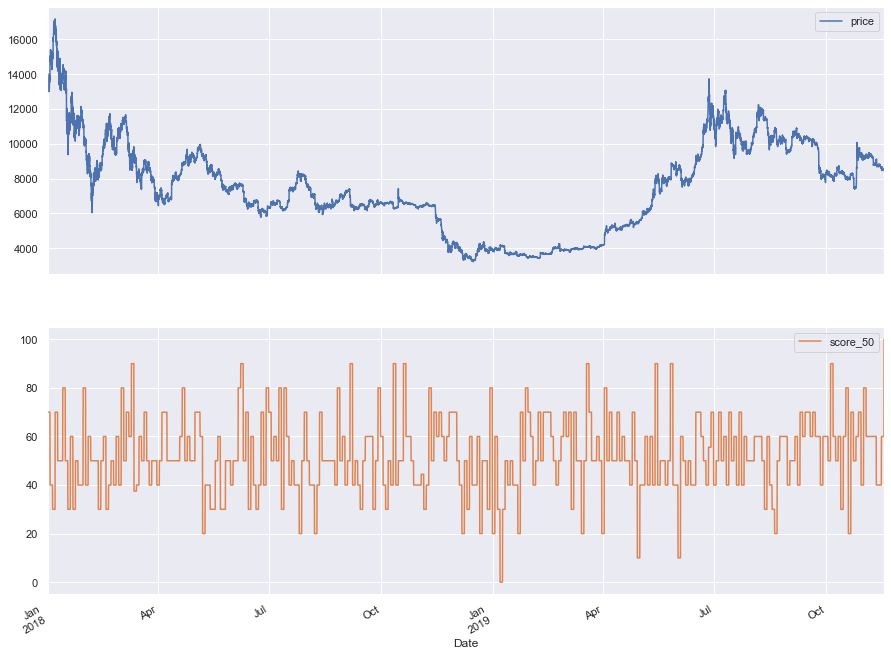

In [367]:
main.iloc[2000:,][['price','score_50']].plot(figsize=(15,12) , subplots=(2,1) ) # 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D725254148>,
      dtype=object)

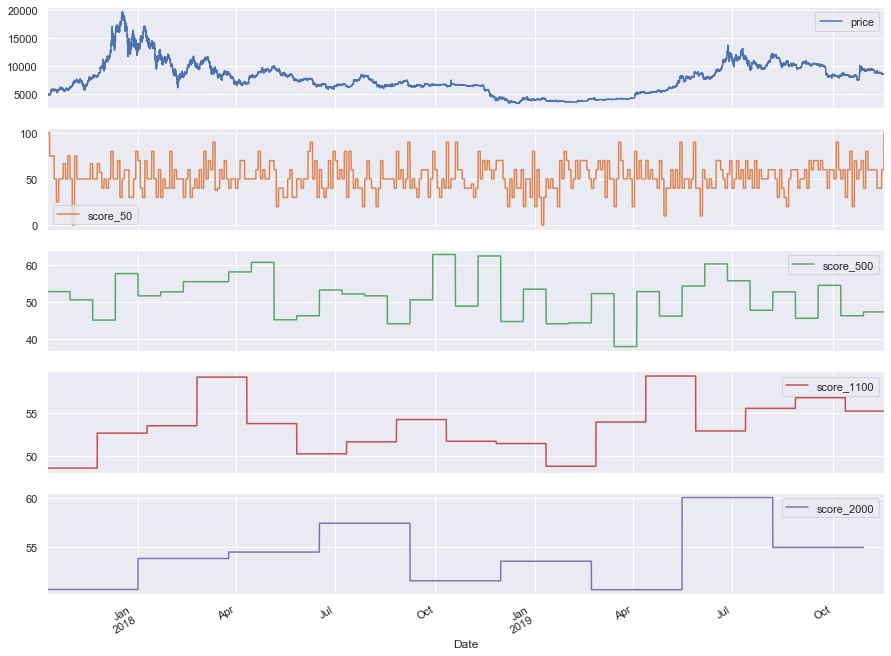

In [369]:
main[['price','score_50', 'score_500', 'score_1100', 'score_2000']].plot(figsize=(15,12) , subplots=(2,1) ) # 

In [360]:
np.sqrt(0.50)

0.7071067811865476

In [279]:
main[['returns','score_50', 'score_500', 'score_1100']].rolling(300).mean().mean()

returns        0.000075
score_50      52.187302
score_500     51.282096
score_1100    53.508582
dtype: float64

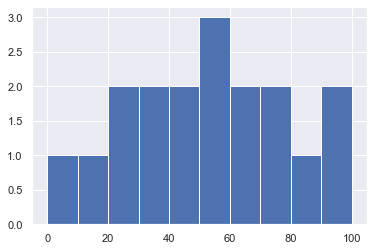

In [276]:
main.score_50.drop_duplicates().hist()

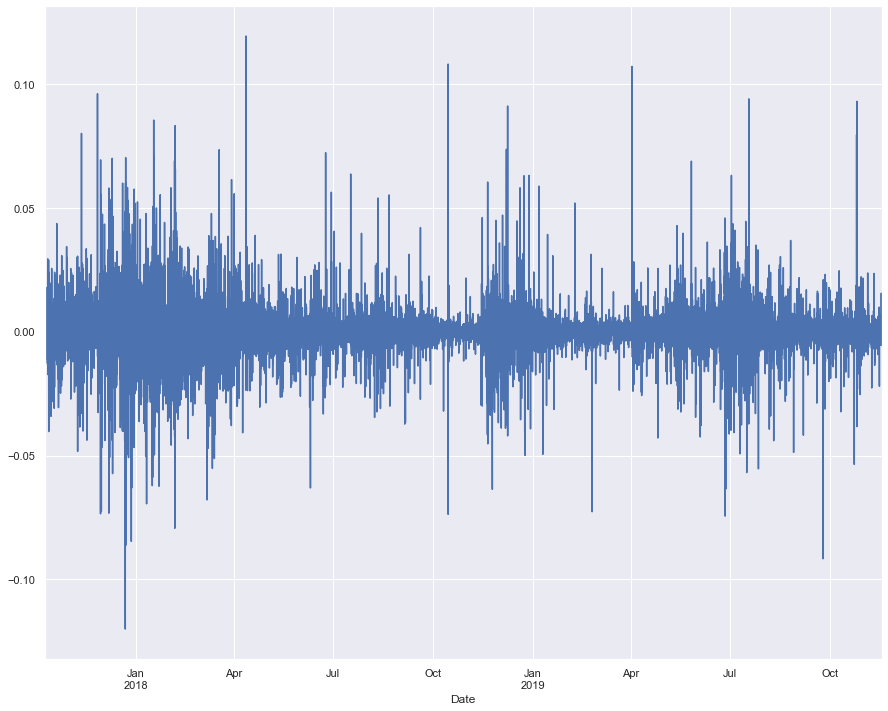

In [292]:
main['returns'].plot(figsize=(15,12))

In [1014]:
# best accuracy ROC(300)

In [1015]:
accuracy_cols = ['score_50', 'score_100', 'score_200', 'score_500', 'score_800', 'score_1100']

In [1016]:
# ma 100 diff
# ma 100, roc 5
# 800, 50 roc
# 100, 50

In [1017]:
rand_list = list(rand_list)

In [1018]:
import time

In [1063]:
from sklearn.preprocessing import StandardScaler

In [1064]:
scaler = StandardScaler()

In [1310]:
# combining with accuracy 100 period momentum best result
res = generate_features(main).fillna(0)
#res = main
res = pd.DataFrame(scaler.fit_transform(main), index=main.index, columns=main.columns )

size = res.shape[0]
res.loc[:, ['score_50', 'score_100', 'score_200', 'score_500', 'score_800', 'score_1100']]=res[['score_50', 'score_100', 'score_200', 'score_500', 'score_800', 'score_1100']].pct_change(1).fillna(0)
#tmp = res[['score_50', 'score_100', 'score_200', 'score_500', 'score_800', 'score_1100']].pct_change(1).fillna(0)

#diff = res[accuracy_cols] - res[accuracy_cols].rolling(8).mean().fillna(method='bfill')
#roc = res[accuracy_cols].rolling(8).mean().fillna(method='bfill').pct_change(5).fillna(0)

#res = res.join(tmp.add_prefix('_roc1'))
#res = res.join(diff.add_prefix('_diff'))
#res = res.join(roc.add_prefix('_roc'))

df = res.copy()    
df = df.replace([np.inf, -np.inf],0).fillna(0)

df['shift_returns'] = df['returns'].shift(-1).dropna()
df = df[df.shift_returns != 0.0].dropna()

y = df.iloc[:, -1].copy()
y = np.sign(y)
X = df.iloc[:, :-1].copy()
X = X.fillna(0)

random_state=0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X = X.reset_index(drop=True)
#print('division:',0, size*0.8)
X_train =X.loc[0:int(size*0.80)]
y_train = y.loc[0:int(size*0.80)]

X_test = X.loc[int(size*0.80)+5:size]
y_test = y.loc[int(size*0.80)+5:size]

clf = RandomForestClassifier(n_estimators=200, max_depth=20,
                             random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

score = accuracy_score(y_test, y_pred)

In [1311]:
score

0.4690635451505017

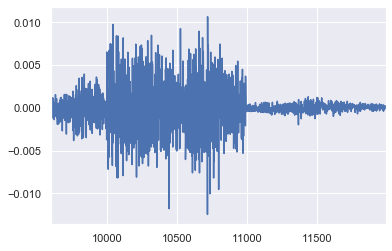

In [1075]:
main.loc[int(size*0.80)+5:size]['returns'].plot()

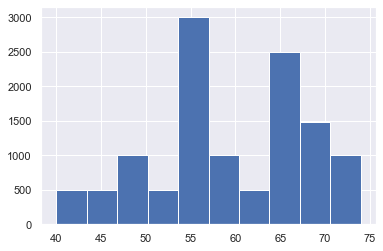

In [1081]:
main['score_500'].hist()

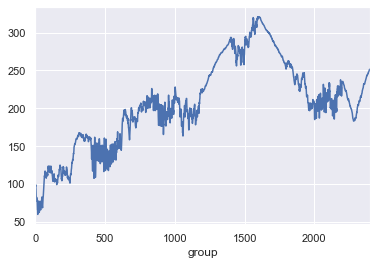

In [1106]:
main['group'] = (main.index/5).astype('int')
main.groupby('group').mean()['price'].plot()

In [1364]:
weekly_main = main[['price', 'group', 'score_50', 'score_100', 'score_200', 'score_500', 'score_800', 'score_1100']].groupby('group').last().reset_index(drop=True).copy()

In [1365]:
weekly_main['returns'] = weekly_main.price.pct_change()

In [1393]:
# combining with accuracy 100 period momentum best result
# higher timeframe is best case
res = generate_features(weekly_main).fillna(0)
#res = main
#res = pd.DataFrame(scaler.fit_transform(weekly_main), index=weekly_main.index, columns=weekly_main.columns )
res['original_returns'] = weekly_main['ROC_5']
res = res[res.original_returns.fillna(0) !=0.0]
size = res.shape[0]
#res.loc[:, ['score_50', 'score_100', 'score_200', 'score_500', 'score_800', 'score_1100']]=res[['score_50', 'score_100', 'score_200', 'score_500', 'score_800', 'score_1100']].pct_change(300).fillna(0)

tmp = res[['score_50', 'score_100', 'score_200', 'score_500', 'score_800', 'score_1100']].pct_change(1).fillna(0)

diff = res[accuracy_cols] - res[accuracy_cols].rolling(8).mean().fillna(method='bfill')
roc = res[accuracy_cols].rolling(8).mean().fillna(method='bfill').pct_change(5).fillna(0)

res = res.join(tmp.add_prefix('_roc1'))
res = res.join(diff.add_prefix('_diff'))
res = res.join(roc.add_prefix('_roc'))

df = res.copy()    
df = df.replace([np.inf, -np.inf],0).fillna(0)

df['shift_returns'] = df['original_returns'].shift(-1).dropna()
df.drop(columns='original_returns', inplace=True)
df = df[df.shift_returns != 0.0].fillna(0)
df =df.reset_index(drop=True)
y = df.iloc[:, -1].copy()

y = np.sign(y)
X = df.iloc[:, :-1].copy()
X = X.fillna(0)

random_state=0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X = X.reset_index(drop=True)

#print('division:',0, size*0.8)
X_train =X.loc[0:int(size*0.80)]
y_train = y.loc[0:int(size*0.80)]

X_test = X.loc[int(size*0.80)+5:size]
y_test = y.loc[int(size*0.80)+5:size]

clf = RandomForestClassifier(n_estimators=200, max_depth=20,
                             random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

score = accuracy_score(y_test, y_pred)

In [1394]:
score

0.8270042194092827

In [1322]:
### summary overall
## combination with accuracy and random dtection indicators does not improve accuracy of model, or improve a little
# resampling into higher timeframe is best case
# standard scaling is best improver

# next things to test
# data with short period of accuracy estimation ml models
# apply ml with large data size


In [1464]:
dataset = weekly_main[['price', 'returns', 'score_50', 'score_100', 'score_200']]

In [2063]:
main = dataset.copy()

In [2064]:
# combining with accuracy 100 period momentum best result
res = generate_features(main).fillna(0)
res = main
#res = pd.DataFrame(scaler.fit_transform(main), index=main.index, columns=main.columns )

size = res.shape[0]
#res.loc[:, ['score_50', 'score_100', 'score_200', 'score_500', 'score_800', 'score_1100']]=res[['score_50', 'score_100', 'score_200', 'score_500', 'score_800', 'score_1100']].pct_change(1).fillna(0)
#tmp = res[['score_50', 'score_100', 'score_200', 'score_500', 'score_800', 'score_1100']].pct_change(1).fillna(0)

#diff = res[accuracy_cols] - res[accuracy_cols].rolling(8).mean().fillna(method='bfill')
#roc = res[accuracy_cols].rolling(8).mean().fillna(method='bfill').pct_change(5).fillna(0)

#res = res.join(tmp.add_prefix('_roc1'))
#res = res.join(diff.add_prefix('_diff'))
#res = res.join(roc.add_prefix('_roc'))

df = res.copy()    
df = df.replace([np.inf, -np.inf],0).fillna(0)

df['shift_returns'] = df['returns'].shift(-1).dropna()
df = df[df.shift_returns != 0.0].dropna()

y = df.iloc[:, -1].copy()
y = np.sign(y)
X = df.iloc[:, :-1].copy()
X = X.fillna(0)

random_state=0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X = X.reset_index(drop=True)
#print('division:',0, size*0.8)
X_train =X.loc[0:int(size*0.80)]
y_train = y.loc[0:int(size*0.80)]

X_test = X.loc[int(size*0.80)+5:size]
y_test = y.loc[int(size*0.80)+5:size]

clf = RandomForestClassifier(n_estimators=200, max_depth=20,
                             random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

score = accuracy_score(y_test, y_pred)

In [2065]:
score

0.5654008438818565

In [2066]:
pd.DataFrame(scores_list).groupby(0).mean().sort_values(by=1)

,1
0,
50,56.020833
800,57.216772
100,57.650602
200,58.275219
500,58.471366
1100,60.052448


In [2067]:
# with accuracy scores
pd.DataFrame(scores_list).groupby(0).mean().sort_values(by=1)

,1
0,
50,56.020833
800,57.216772
100,57.650602
200,58.275219
500,58.471366
1100,60.052448


In [2068]:
b =pd.DataFrame(list(zip(y_test, y_pred)))
trading_df = X_test[['score_50', 'score_100', 'score_200']].reset_index(drop=True).join(b)
trading_df = trading_df.rename(columns={0:'actual', 1:'predicted'})
trading_df['profit'] = trading_df.actual * trading_df.predicted
trading_df.profit.cumsum().pct_change(3).replace([np.inf, -np.inf],0).fillna(0).mean()*252 / (trading_df.profit.cumsum().pct_change(3).replace([np.inf, -np.inf],0).fillna(0).std() * np.sqrt(252))

0.5344878519646425

In [2069]:
trading_df.shape

(474, 6)

In [2070]:
df = trading_df.sample(400, random_state=0).reset_index(drop=True)

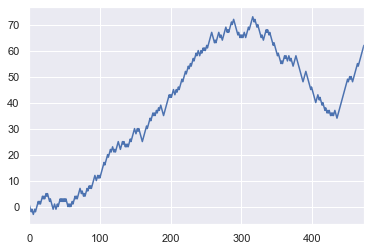

In [2071]:
trading_df['profit'].cumsum().plot()

In [2072]:
df['profit'].reset_index(drop=True).cumsum().tail()

395    40.0
396    41.0
397    40.0
398    39.0
399    38.0
Name: profit, dtype: float64

In [2073]:
df['cum_sum'] = df['profit'].reset_index(drop=True).cumsum()

In [2074]:
df['cum_sum_roc'] = df['cum_sum'].pct_change().replace([np.inf, -np.inf],0).fillna(0)

In [2075]:
df['cum_sum_roc5'] = df['cum_sum'].pct_change(20).replace([np.inf, -np.inf],0).fillna(0)

In [2076]:
df.columns

Index(['score_50', 'score_100', 'score_200', 'actual', 'predicted', 'profit',
       'cum_sum', 'cum_sum_roc', 'cum_sum_roc5'],
      dtype='object')

In [2077]:
df.drop(columns=['actual', 'predicted','profit'], inplace=True)


In [2078]:
df['class'] = np.sign(df['cum_sum_roc5'])

In [2079]:
df = df[df['class']!=0.0]
df['class'] = df['class'].astype('category')

In [2080]:
X = df.drop(columns=['cum_sum', 'cum_sum_roc', 'cum_sum_roc5', 'class'])

In [2081]:
y=df['class']

In [2163]:
autoCorrel(df['score_200'], 3)

0.03264246209311664

In [2150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X = X.reset_index(drop=True)
#print('division:',0, size*0.8)

size = X.shape[0]
X_train =X.loc[0:int(size*0.80)]
y_train = y.loc[0:int(size*0.80)]

X_test = X.loc[int(size*0.80):size]
y_test = y.loc[int(size*0.80):size]

clf = RandomForestClassifier(n_estimators=200, max_depth=20,
                             random_state=0)
clf.fit(X_train, y_test)

y_pred = clf.predict(X_train)

score = accuracy_score(y_test, y_pred)

ValueError: Number of labels=53 does not match number of samples=244

In [2144]:
X_train.shape

(244, 3)

In [2145]:
X.shape[0]*0.2

60.800000000000004

In [2148]:
y_test.shape

(53,)

In [2143]:
score

0.6973684210526315

In [2114]:
### practical application

In [2117]:
trading_df['entry'] = clf.predict(trading_df[['score_50', 'score_100', 'score_200']])

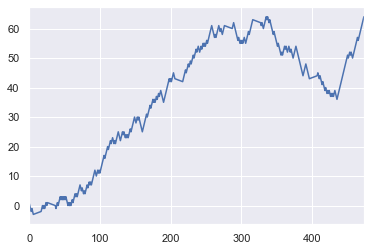

In [2122]:
trading_df[trading_df.entry==1]['profit'].cumsum().plot()

In [2164]:
# need to think how to split test and train dataset for practical purposes
# shift , we know market regive after trade completion
# rolling ML

In [1649]:
# https://docs.pymc.io/notebooks/GLM-rolling-regression.html
# https://pypi.org/project/pyfinance/
# https://www.statsmodels.org/dev/examples/notebooks/generated/rolling_ls.html